In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import ticker
import pandas as pd

### pretrain/oracle klom distribution vs. number of models N

In [ ]:
# ---------------------------- basic parameters --------------------------- #
tmp_dir     = Path("./tmp")                # where klom_*.pt live
forget_ids  = range(1, 9)                  # 1 … 8
n_values    = np.linspace(2, 100, 20, dtype=int)
figsize     = (18, 32)
# ------------------------------------------------------------------------- #

# ---------------------------- load everything ---------------------------- #
data = {fid: {"forget": {}, "retain": {}, "val": {}} for fid in forget_ids}

for n in n_values:
    res = torch.load(tmp_dir / f"klom_{n}.pt", map_location="cpu")
    for fid in forget_ids:
        for cat in ("forget", "retain", "val"):
            data[fid][cat][n] = np.asarray(res[cat][fid])

# ---------------------------- start plotting ----------------------------- #
plt.style.use("seaborn-v0_8-whitegrid")

n_rows, n_cols = len(forget_ids), 3
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=figsize,
                         sharex=False, sharey=False,   # every subplot shows ticks
                         constrained_layout=True)

# ⬤ / ◆ marker styles for percentiles
percentiles = {
    95: dict(marker="o", ms=7, mfc="red",   mec="darkred",   label="95 %"),
    99: dict(marker="D", ms=7, mfc="green", mec="darkgreen", label="99 %")
}

for row, fid in enumerate(forget_ids):
    for col, cat in enumerate(("forget", "retain", "val")):
        ax = axes[row, col]

        # ----------- box-plot data in n-value order -------------------- #
        series = [np.asarray(data[fid][cat][n]) for n in n_values]

        ax.boxplot(series,
                   positions=n_values,
                   patch_artist=True,            # allow face colour
                   widths=1.5,
                   boxprops   =dict(facecolor="#8ecae6", edgecolor="black", linewidth=1),
                   medianprops=dict(color="#023047", linewidth=1.4),
                   whiskerprops=dict(color="black", linewidth=1),
                   capprops   =dict(color="black", linewidth=1),
                   flierprops =dict(marker=".", markersize=2, alpha=0.4),
                   manage_ticks=False)

        # ----------- overlay 95-th & 99-th percentile markers ---------- #
        for p, style in percentiles.items():
            y = [np.percentile(s, p) for s in series]
            kwargs = {k: v for k, v in style.items() if k != "label"}
            ax.plot(n_values, y, linestyle="None", **kwargs)

        # ---------------- axis cosmetics ------------------------------- #
        ax.set_xticks(n_values)
        ax.set_xticklabels(n_values, rotation=45, ha="right", fontsize=9)
        ax.set_yticks(ax.get_yticks())
        ax.tick_params(axis="y", labelsize=9)
        ax.set_xlabel("number of pre-trained models $N$", fontsize=11)
        ax.set_ylabel(r"$\operatorname{KLOM}$", fontsize=11)
        ax.set_title(cat.upper(), fontsize=12, pad=6)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

    # -------- row title spanning the three panels --------------------- #
    axes[row, 1].annotate(f"Forget Set {fid}",
                          xy=(0.5, 1.12), xycoords="axes fraction",
                          ha="center", va="bottom",
                          fontsize=13, fontweight="bold")

# ------------------------- single shared legend -------------------------- #
handles, labels = [], []
for p, style in percentiles.items():
    h, = axes[0, 0].plot([], [], **{k: v for k, v in style.items() if k != "label"})
    handles.append(h); labels.append(style["label"])
fig.legend(handles, labels,
           loc="upper right",
           bbox_to_anchor=(0.99, 1.01),
           frameon=True,
           fontsize=13,
           edgecolor='black',
           fancybox=False)

fig.suptitle("KLOM distribution vs. number of models $N$",
             fontsize=16, y=1.02, fontweight="bold")

plt.savefig("klom_distribution.png")
plt.show()

### klom plots

In [18]:
from paths import EVAL_DIR, FORGET_INDICES_DIR
from ast import literal_eval
from datasets import DATASETS
dataset_name = "cifar10"
model_name = "resnet9"
KLOM_PATH = EVAL_DIR / dataset_name / model_name
FDIR = FORGET_INDICES_DIR / dataset_name
forget_sets = [1,2,3,4,5,6,7,8,9]
TOTAL_EPOCHS = 24
forget_indices = {i: torch.load(FDIR / f"forget_indices_{i}.pt") for i in forget_sets}
train_size = DATASETS[dataset_name]["train_size"]
val_size = DATASETS[dataset_name]["val_size"]
retain_indices = {i: [k for k in range(train_size) if k not in forget_indices[i]] for i in forget_sets}
val_indices = [k for k in range(train_size, train_size+val_size)]

def get_klom_stats(klom, key):
    return {f"{key}_klom_95": np.percentile(klom, 95), f"{key}_klom_99": np.percentile(klom, 99), f"{key}_klom_mean": np.mean(klom), f"{key}_klom_std": np.std(klom)}

def parse_method_fname(fname):
    if "do_nothing" in fname:
        method = "do_nothing"
        fset = int(fname.split("__")[1].split("_")[0][1])
        lr = None
        ep = None
        bs = None
        n = None
        ascent_epochs = None
    elif "ascent_forget" in fname:
        method, lr, ep, fset, bs, lat = fname.split("__")
        lr = float(lr.split("_")[1])
        ep = literal_eval(ep.split("_")[1])
        fset = int(fset[1])
        bs = int(bs.split("bs")[1])
        n = int(lat.split("_")[1].split(".")[0])
        ascent_epochs = None
    elif "scrub" in fname:
        method, lr, ep, fset, bs, ascent_epochs, lat = fname.split("__")
        lr = float(lr.split("_")[1])
        ep = literal_eval(ep.split("_")[1])
        fset = int(fset[1])
        bs = int(bs.split("bs")[1])
        n = int(lat.split("_")[1].split(".")[0])
        ascent_epochs = int(ascent_epochs.split("ascent_epochs")[1])
    return method, lr, ep, fset, bs, n, ascent_epochs

def parse_klom_fname(fname):
    method, lr, ep, fset, bs, n, ascent_epochs = parse_method_fname(fname)
    res = torch.load(KLOM_PATH / fname)
    rows = []
    for e_id, klom in res.items():
        total_cost = (len(forget_indices[fset]) + len(retain_indices[fset]) + len(val_indices)) * TOTAL_EPOCHS
        if method == "ascent_forget":
            relative_cost = len(forget_indices[fset]) * e_id / total_cost
        elif method == "do_nothing":
            relative_cost = 0
        elif method == "scrub":
            relative_cost = (len(forget_indices[fset]) * ascent_epochs + len(retain_indices[fset]) * e_id) / total_cost
        else:
            raise NotImplementedError(f"Cost for {method} not implemented")
        assert method == "do_nothing" or e_id in ep, f"e_id {e_id} not in ep {ep}"
        rows.append(
            {
                "method": method,
                "lr": lr,
                "epoch": e_id,
                "forget_id": fset,
                "batch_size": bs,
                "N": n,
                "ascent_epochs": ascent_epochs,
                "relative_cost": relative_cost,
                **get_klom_stats(klom[retain_indices[fset]], "retain"),
                **get_klom_stats(klom[val_indices], "val"),
                **get_klom_stats(klom[forget_indices[fset]], "forget"),
            }
        )
    return rows

contents = []
for fname in KLOM_PATH.iterdir():
    contents.extend(parse_klom_fname(fname.name))

In [19]:
tmp_dir = Path("./tmp2")
rows = []
for fname in tmp_dir.iterdir():
    if "kl" in fname.name:
        _, forget, epoch = fname.name.split("__")
        forget_id = int(forget[1])
        epoch = int(epoch.split(".")[0])
        kl = torch.load(fname)
        if forget_id not in forget_indices:
            continue
        rows.append({
            "method": "retrain",
            "forget_id": forget_id,
            "epoch": epoch,
            "lr": None,
            "batch_size": None,
            "ascent_epochs": None,
            "N": None,
            "relative_cost": epoch / TOTAL_EPOCHS,
            **get_klom_stats(kl[retain_indices[forget_id]], "retain"),
            **get_klom_stats(kl[val_indices], "val"),
            **get_klom_stats(kl[forget_indices[forget_id]], "forget"),
        })
contents.extend(rows)

In [28]:
df = pd.DataFrame(contents)
df["average_95"] = df.apply(lambda x: (x["retain_klom_95"] + x["val_klom_95"] + x["forget_klom_95"]) / 3, axis=1)
print(df.head().to_string(index=False))

       method     lr  epoch  forget_id  batch_size     N  ascent_epochs  relative_cost  retain_klom_95  retain_klom_99  retain_klom_mean  retain_klom_std  val_klom_95  val_klom_99  val_klom_mean  val_klom_std  forget_klom_95  forget_klom_99  forget_klom_mean  forget_klom_std  average_95
ascent_forget 0.0001      1          6        64.0 100.0            NaN       0.000347        2.945282        5.096116          0.842433         0.960452     2.332662     5.460636       0.713353      0.938842        9.767871        9.950356          6.834394         2.670681    5.015272
ascent_forget 0.0001      3          6        64.0 100.0            NaN       0.001042        8.392753        9.421544          2.328892         2.350136     7.492885     9.185561       1.736552      2.083708        9.681126        9.913938          7.901171         2.805386    8.522255
ascent_forget 0.0001      5          6        64.0 100.0            NaN       0.001736        9.392012        9.738857          3.318720

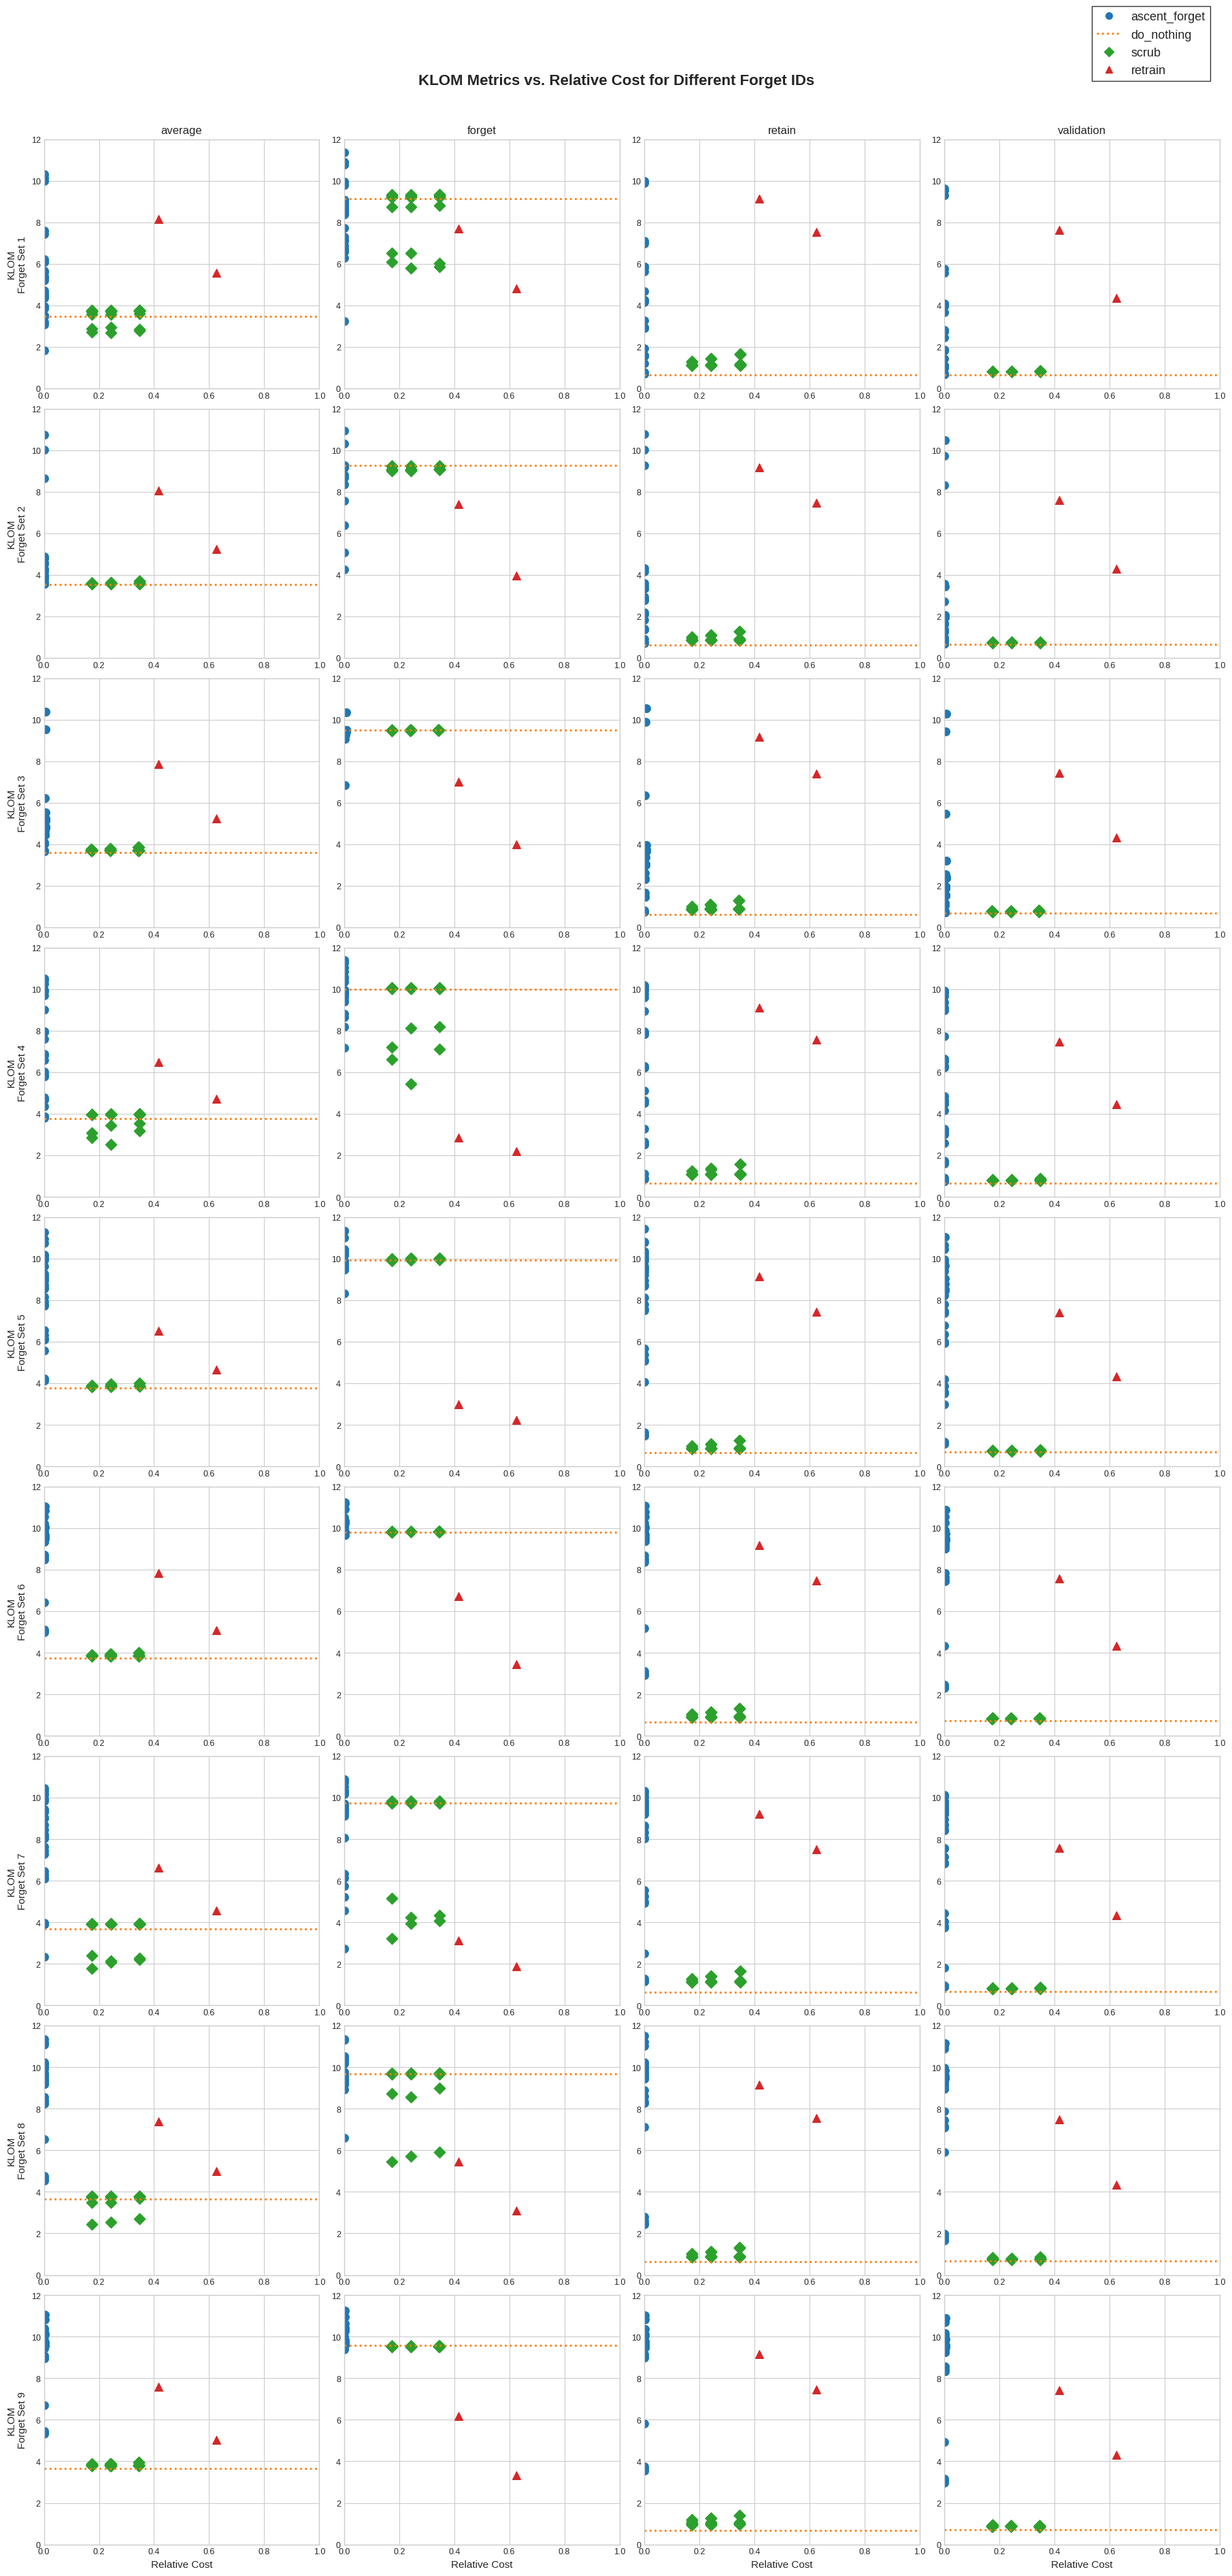

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

forget_ids = sorted(df['forget_id'].unique())
metrics     = ['average_95', 'forget_klom_95', 'retain_klom_95', 'val_klom_95']
titles      = ['average',    'forget',         'retain',         'validation']

figsize = (18, 4 * len(forget_ids))
methods = df['method'].unique()

# -- style helpers -----------------------------------------------------------
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*']          # extend if needed
colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_map = {m: markers[i % len(markers)] for i, m in enumerate(methods)}
color_map  = {m: colors[i % len(colors)]  for i, m in enumerate(methods)}

line_method = "do_nothing"          # <- the method you want as a dotted line

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(len(forget_ids),
                         len(metrics),
                         figsize=figsize,
                         sharex=False, sharey=False,
                         constrained_layout=True)

if len(forget_ids) == 1:
    axes = [axes]                              # 1-row convenience

# --------------------------------------------------------------------------- #
for row_idx, fid in enumerate(forget_ids):
    df_fid = df[df['forget_id'] == fid]

    for col_idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[row_idx][col_idx] if len(forget_ids) > 1 else axes[col_idx]

        for method in methods:
            df_method = df_fid[df_fid['method'] == method]

            if method == line_method and not df_method.empty:
                # a single horizontal dotted line across the whole x-range
                y = df_method[metric].iloc[0]
                ax.hlines(y, xmin=0, xmax=1,
                          color=color_map[method],
                          linestyle=':',
                          linewidth=2,
                          label=method)
            else:
                ax.scatter(df_method['relative_cost'], df_method[metric],
                           marker=marker_map[method],
                           color=color_map[method],
                           s=70,
                           label=method)

        # labels / titles
        if row_idx == len(forget_ids) - 1:
            ax.set_xlabel('Relative Cost', fontsize=11)
        if col_idx == 0:
            ax.set_ylabel(f'KLOM\nForget Set {fid}', fontsize=11)
        if row_idx == 0:
            ax.set_title(title, fontsize=12, pad=6)

        ax.tick_params(axis='both', which='both', labelsize=9)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 12)

# legend ---------------------------------------------------------------------#
handles = []
for method in methods:
    if method == line_method:
        h = plt.Line2D([], [], linestyle=':',
                       linewidth=2,
                       color=color_map[method],
                       label=method)
    else:
        h = plt.Line2D([], [], linestyle='None',
                       marker=marker_map[method],
                       color=color_map[method],
                       markersize=7,
                       label=method)
    handles.append(h)

fig.legend(handles, methods,
           loc="upper right",
           bbox_to_anchor=(0.99, 1.05),
           frameon=True,
           fontsize=13,
           edgecolor='black',
           fancybox=False)

fig.suptitle("KLOM Metrics vs. Relative Cost for Different Forget IDs",
             fontsize=16, y=1.02, fontweight="bold")

plt.show()


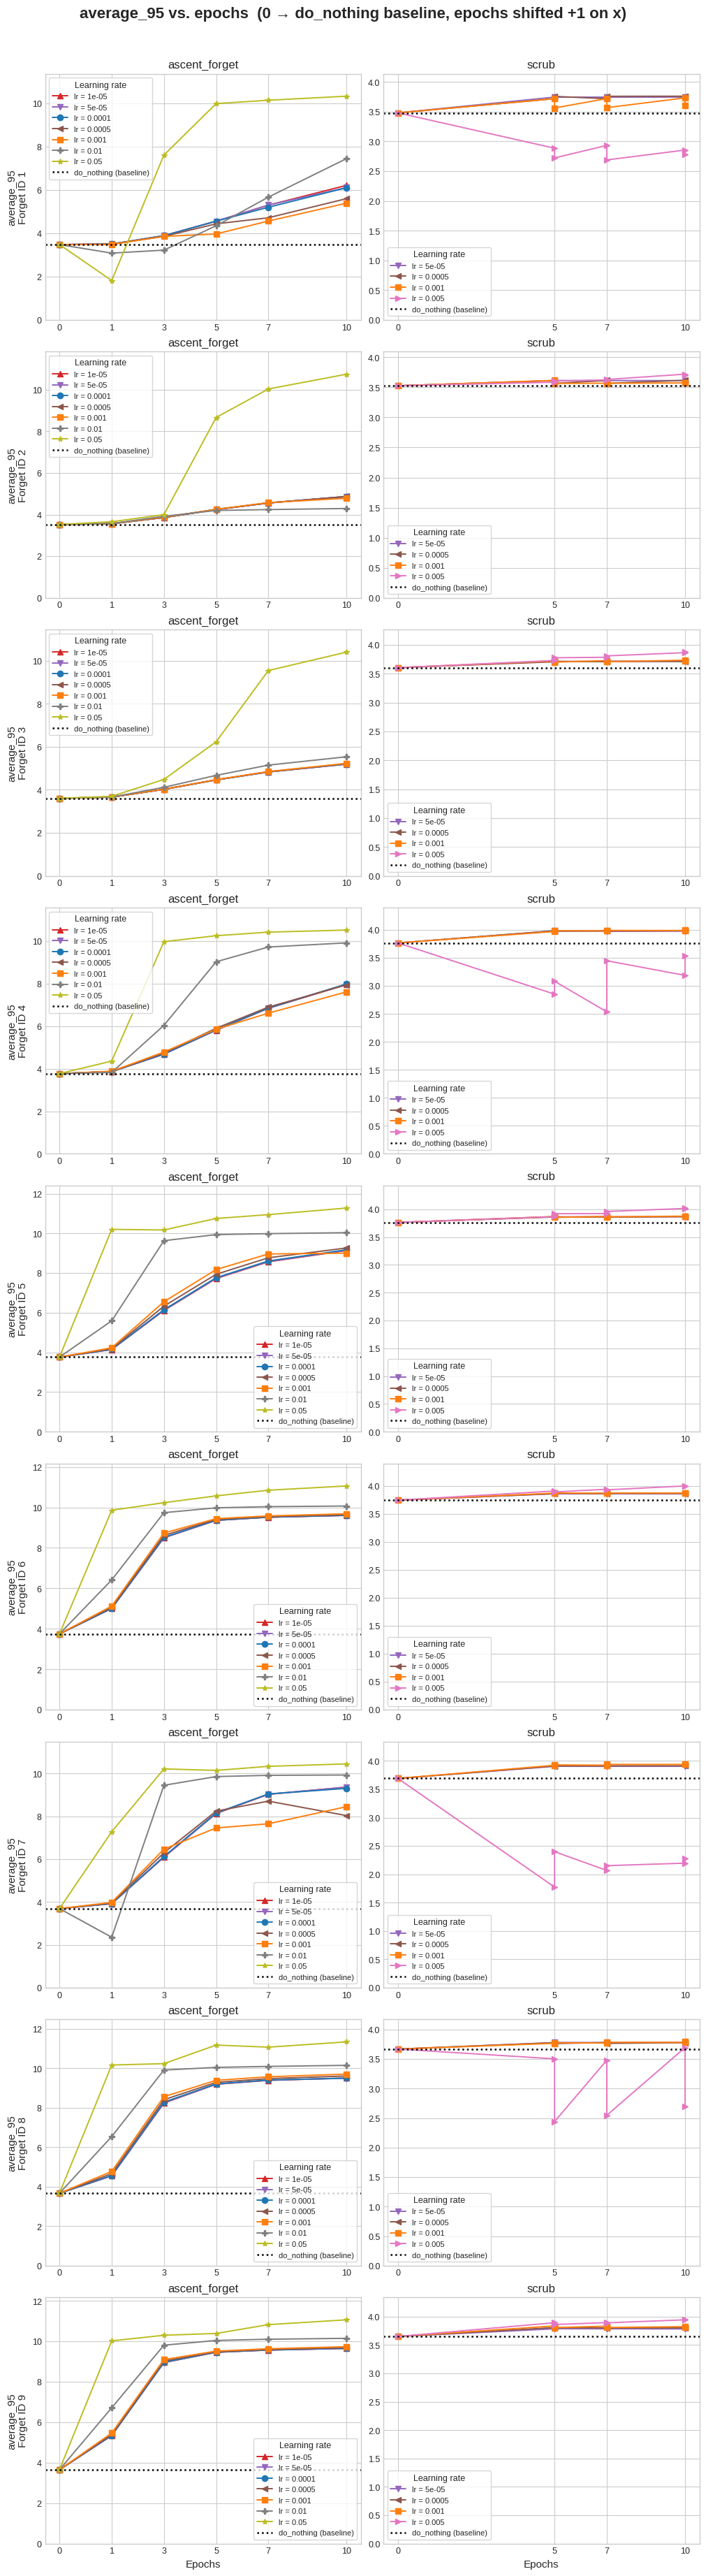

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------------ #
# 1) CONFIGURABLE INPUTS ­– tweak these three variables only
# ------------------------------------------------------------------ #
selected_forget_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9]     # rows
selected_methods    = ['ascent_forget', 'scrub']      # columns (no do_nothing)
line_method         = 'do_nothing'                    # baseline
# ------------------------------------------------------------------ #

plt.style.use("seaborn-v0_8-whitegrid")

# --- palettes keyed by learning-rate -------------------------------------- #
lrs        = sorted(df['lr'].unique())
palette    = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers    = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*']
lr_colors  = {lr: palette[i % len(palette)] for i, lr in enumerate(lrs)}
lr_markers = {lr: markers[i % len(markers)] for i, lr in enumerate(lrs)}

# --- figure grid ----------------------------------------------------------- #
n_rows, n_cols = len(selected_forget_ids), len(selected_methods)
figsize = (5 * n_cols, 4 * n_rows)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=figsize,
                         sharex=False, sharey=False,
                         constrained_layout=True)

# normalise axes for single-row/col cases
if n_rows == 1 and n_cols == 1:
    axes = [[axes]]
elif n_rows == 1:
    axes = [axes]
elif n_cols == 1:
    axes = [[ax] for ax in axes]

# --------------------------------------------------------------------------- #
for r, fid in enumerate(selected_forget_ids):

    # baseline value (do_nothing) for this forget-set ----------------------- #
    base_subset = df[(df['method'] == line_method) & (df['forget_id'] == fid)]
    base_y = None if base_subset.empty else base_subset['average_95'].iloc[0]

    for c, method in enumerate(selected_methods):
        ax = axes[r][c]
        subset = df[(df['forget_id'] == fid) & (df['method'] == method)]

        if subset.empty:
            ax.text(0.5, 0.5, 'no data',
                    ha='center', va='center', fontsize=10,
                    transform=ax.transAxes)
            continue

        # one curve per learning-rate ------------------------------------- #
        for lr in sorted(subset['lr'].unique()):
            df_lr = subset[subset['lr'] == lr].sort_values('epoch')
            if df_lr.empty:
                continue

            # x-coords: prepend 0, then real_epoch + 1
            x_plot = [0] + (df_lr['epoch'] + 1).tolist()
            y_plot = ([base_y] if base_y is not None else []) + df_lr['average_95'].tolist()

            ax.plot(x_plot, y_plot,
                    marker=lr_markers[lr],
                    linestyle='-',
                    linewidth=1.4,
                    markersize=6,
                    color=lr_colors[lr],
                    label=f'lr = {lr:g}')

        # dotted horizontal baseline -------------------------------------- #
        if base_y is not None:
            ax.axhline(base_y,
                       linestyle=':',
                       linewidth=1.8,
                       color='black',
                       label='do_nothing (baseline)')

        # cosmetics -------------------------------------------------------- #
        if r == n_rows - 1:
            ax.set_xlabel('Epochs', fontsize=11)
        if c == 0:
            ax.set_ylabel(f'average_95\nForget ID {fid}', fontsize=11)

        ax.set_title(method, fontsize=12, pad=6)
        ax.tick_params(axis='both', which='both', labelsize=9)

        # x-ticks: 0 plus real epochs (plotted at epoch+1, labelled as epoch)
        real_eps = sorted(subset['epoch'].unique())
        xticks   = [0] + [e + 1 for e in real_eps]
        xlabels  = ['0'] + [str(e) for e in real_eps]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)

        ax.set_ylim(0, subset['average_95'].max() * 1.10)

        # per-subplot legend
        ax.legend(title='Learning rate',
                  fontsize=8,
                  title_fontsize=9,
                  frameon=True,
                  loc='best')

# --------------------------------------------------------------------------- #
fig.suptitle('average_95 vs. epochs  (0 → do_nothing baseline, epochs shifted +1 on x)',
             fontsize=16, y=1.02, fontweight='bold')
plt.show()